In [8]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pylab as plt
from scipy.fft import fft, fftfreq
from scipy import signal
import glob
import os
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
import tsfel

Import data.

In [9]:
data_dir = os.path.expanduser("~/Documents/Senior/Fall/Clinic/Data Cleaner/tarsalis_data_clean")
os.chdir(data_dir)
filenames = glob.glob('*.csv')
dataframes = [pd.read_csv(f) for f in filenames]

In [80]:
filenames

['cxthand1sep2021no1.csv',
 'cxthand1sep2021no7.csv',
 'cxthand30aug2021no11.csv',
 'cxthand30aug2021no12.csv',
 'cxthand30aug2021no2.csv',
 'cxthand8sep2021no1.csv',
 'cxthand8sep2021no4.csv',
 'cxthand8sep2021no8.csv',
 'cxtonhand10nov2021no10.csv',
 'cxtonhand10nov2021no11.csv',
 'cxtonhand10nov2021no5.csv',
 'cxtonhand10nov2021no7.csv',
 'cxtonhand14dec2021no1.csv',
 'cxtonhand14jan2021no1.csv',
 'cxtonhand14jan2021no3.csv',
 'cxtonhand14jan2021no8.csv',
 'cxtonhand18nov2021no4.csv',
 'cxtonhand18nov2021no8.csv',
 'cxtonhand19nov2021no2b.csv',
 'cxtonhand19nov2021no5.csv',
 'cxtonhand19nov2021no7b.csv',
 'cxtonhand21oct2021no4.csv',
 'cxtonhand21oct2021no6b.csv',
 'cxtonhand21sep2021no8.csv',
 'cxtonhand22oct2021no7.csv',
 'cxtonhand22sep2021no4.csv',
 'cxtonhand22sep2021no6.csv',
 'cxtonhand22sep2021no7.csv',
 'cxtonhand22sep2021no8.csv',
 'cxtonhand22sep2021no9.csv',
 'cxtonhand24nov2021no12.csv',
 'cxtonhand24nov2021no9.csv',
 'cxtonhand27oct2021no9.csv',
 'cxtonhand30nov2021no1

Extract change points from each dataframe for later comparison. Additionally, we will remove datapoints before the first time the signal goes positive and after the last time it goes negative. The signal before and after these points is not biologically significant and the large jumps that occur around these time steps are likely confusing for changepoint analysis.

In [3]:
changepoints = []
time_series = []
rect_series = []
label_series = []
volts = []
currents = []
for df in dataframes:
    volts.append(df["voltage"].values[0])
    currents.append(0 if df["current"].values[0] == "DC" else 1)
    x = df["pre_rect"].values
    rect = df["post_rect"].values
    first_time = np.argmax(x > 0)
    last_time = len(x) - np.argmax(x[::-1] > 0)
    cp = []
    labels = df["labels"].values[first_time:last_time]
    for i in range(len(labels)):
        if i > 0:
            if labels[i] != labels[i - 1]:
                cp.append(i)
        if i == len(labels) - 1:
            cp.append(i)
    time_series.append(x[first_time:last_time])
    rect_series.append(rect[first_time:last_time])
    changepoints.append(cp)
    label_series.append(labels)

Split series by probes.

In [4]:
test_indices = list(range(len(time_series)))[:12]
split_recording = []
split_location  = []
for recording in test_indices:
    # Find where NP is
    sample_rate = 100
    window = 5 * sample_rate
    smoothed = np.convolve(time_series[recording], np.ones(window), "same")/window
    # Essentially, NP is where the signal is close to 0
    is_NP = smoothed < 0.1

    # Find the end of each NP section
    splits = []
    in_NP = False
    for i in range(len(is_NP)):
        if is_NP[i]:
            in_NP = True
        elif in_NP:
                splits.append(i)
                in_NP = False

    # Remove sections that are too short, also shift them all backwards a few seconds so they
    # also include the upgoing signal.
    min_probe_length = 15 * sample_rate # This is made up
    filtered_splits = []
    for i in range(len(splits) - 1):
        if splits[i + 1] - splits[i] > min_probe_length:
            filtered_splits.append(splits[i] - 5 * sample_rate)
    filtered_splits.append(splits[-1] - 5 * sample_rate)

    # Split into probes
    probes = np.split(rect_series[recording], filtered_splits)
        
    split_recording.append(probes)
    split_location.append(filtered_splits)

In [69]:
def probe_splitter(recording, window = 500, threshold = 0.2,
                   min_probe_length = 1500, np_pad = 500, baseline = 7.4):
    """
    Input: recording: A pre-rectified mosquito recording as an 1-D nupmy 
             array. Pre-rectified recordings are necessary as baseline is 
             not 0 in post-rectified recordings.
           window: Before NP regions can be identified, a rolling
             average filter is applied to remove noise in the NP regions.
             The smoothing_window is the size of this filter in samples.
           threshold: The maximum value of an NP sample.
           min_probe_length: The minimum acceptable length of a probe in
             samples.
           np_pad: the number of NP samples before and after each probe to
             include. Note that high values might result in overlapping with
             the next probe.
    Output: A list of (start sample, end sample) tuples for each probe. By 
            default contains about 5 seconds of NPs at the beginning and end 
            of each probe. We say "about" because this splitting is done
            in an unsupervised manner, although it is largely pretty good.
    """
    plt.plot(recording)
    smoothed = np.convolve(recording, np.ones(window), "same")/window
    is_NP = smoothed - baseline < threshold # NP is where the signal is close to 0
    # Find starts at ends, combine into tuple
    find_sequence = lambda l, seq : [i for i in range(len(l)) if l[i:i+len(seq)] == seq]
    is_NP_list = list(is_NP)
    probe_starts = find_sequence(is_NP_list, [True, False])
    probe_ends = find_sequence(is_NP_list, [False, True])
    probes = zip(probe_starts, probe_ends)
    
    # Remove probes that are too short and pad
    probes = [(start - np_pad, end + np_pad) for start, end in probes if end - start > min_probe_length]
    
    return probes
    

In [35]:
%matplotlib qt

In [79]:
t = probe_splitter(dataframes[5]["post_rect"])
plt.vlines([x[0] for x in t], ymin = 0, ymax = 10)

In [72]:
t

[]

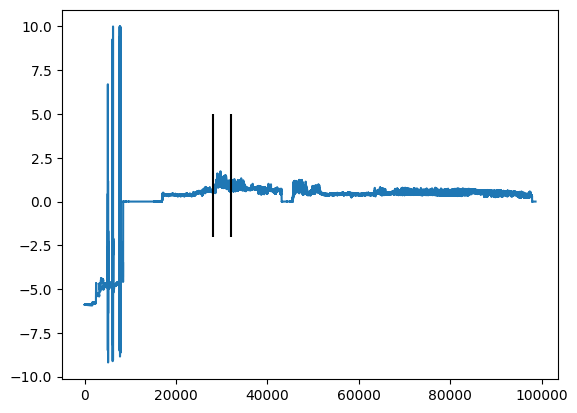

In [11]:
plt.plot(dataframes[1]["pre_rect"])
ls = []
for p in t:
    ls.append(p[0])
    ls.append(p[1])
plt.vlines(ls, ymin = -2, ymax = 5, color = 'black')

In [2]:
a = [True, True, True, False, False, True, True]

[i for i in range(len(a)) if a[i:i+2] == [True, False]]
[i for i in range(len(a)) if a[i:i+2] == [False, True]]


[4]

Function that creates a dataframe with columns for the six most prominent frequencies and one for the label given sections and labels for a time series

In [70]:
hp_filter = signal.butter(4, 5, 'high', fs = sample_rate, output = 'sos')
def gen_stats(sections, labels = [], origin = 0):
    # Calculate statistics for each section
    columns = defaultdict(list)
    for v in sections:
        if len(v) <= 100:
            continue
        filtered = signal.sosfilt(hp_filter, v)
        #section_fft = np.abs(fft(v))[1:len(v)//2]
        #print(len(section_fft), len(v))
        #section_freqs = fftfreq(len(v), 1 / sample_rate)[1:len(v)//2]

        # Get indices with greatest amplitude
        # https://stackoverflow.com/a/20826735
        #num_largest = 6
        #indices = (-section_fft).argpartition(num_largest, axis=None)[:num_largest]
        #indices = sorted(indices, key = lambda x: section_fft[x], reverse = True)
        #peak_freqs = section_freqs[indices]

        #for i in range(num_largest):
        #    columns[f"F{i}"].append(peak_freqs[i])
        #plt.plot(filtered)
        columns["max_freq"].append( 
            tsfel.feature_extraction.max_frequency(v, sample_rate))
        columns["fund_freq"].append( 
            tsfel.feature_extraction.fundamental_frequency(filtered, sample_rate))
        columns["slope"].append(
            tsfel.feature_extraction.features.slope(v))
        columns["entropy"].append(
            tsfel.feature_extraction.features.entropy(v))
        #columns["mean"].append(np.mean(v))
        columns["std"].append(np.std(v))
        #print(origin)
        #columns["volts"].append(volts[origin])
        #columns["current"].append(currents[origin])
        peaks, _ = signal.find_peaks(v)
        #print(len(peaks)
        columns["freq"].append(len(peaks) / (len(v) / sample_rate))
        
    for v, label in zip(sections, labels):
        if len(v) <= 100:
            continue
        if labels:
            columns["label"].append(label)

    return pd.DataFrame(columns)

In [72]:
pd.concat(train_data).groupby('label').mean()

,max_freq,fund_freq,slope,entropy,std,freq
label,,,,,,
J,2.317915,5.455578,0.000301,0.557718,0.086767,18.154924
K,4.294158,4.966628,0.001784,0.828715,0.301613,8.433099
L,2.688366,3.405444,0.000006,0.546094,0.142820,14.239966
M,6.730756,4.018876,-0.000013,0.547185,0.139486,11.418813
N,0.348273,3.831527,-0.000001,0.506743,0.047196,17.775329
NP,3.148939,3.920328,-0.000003,0.340914,0.116897,20.004161


Create a random forests model to classify large chunks.

In [71]:
train_indices = list(range(len(time_series)))[12:]

train_data = []
for recording in train_indices:
    # Split at changepoints
    sections = np.split(rect_series[recording], changepoints[recording])
    # Get the labels for each section
    labels = [l[0] for l in np.split(label_series[recording], changepoints[recording])]

    df_out = gen_stats(sections, labels, recording)
    train_data.append(df_out)
    
train_df = pd.concat(train_data)
X_train = train_df.drop(["label"], axis=1)
Y_train = train_df["label"]

model = RandomForestClassifier(class_weight="balanced")
model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced')

Split the test recordings using ruptures and predict what label each section is.

In [73]:
bp_model = 'normal'
num_breakpoints = 10

split_labels = []
r = 0
for recording in split_recording:
    probe_splits = []
    probe_labels = []

    for probe in recording:
        algo = rpt.BottomUp(model=bp_model).fit(probe) # We can play with this a bit...
        breakpoints = algo.predict(n_bkps = num_breakpoints)
        sections = np.split(probe, breakpoints)
        section_df = gen_stats(sections, origin = r)

        #probe_stats.append(section_df)
        probe_splits.append(breakpoints)
        probe_labels.append(model.predict(section_df))
    
    split = {}
    split['splits'] = probe_splits
    split['labels'] = probe_labels
    
    split_labels.append(split)
    r += 1
    

C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Lo

C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
C:\Users\zbtra\AppData\Lo

Turn the split labels back into a time series of labels.

In [74]:
Y_test = []

for r in range(len(split_recording)):
    labels = split_labels[r]['labels']
    split_locs = split_labels[r]['splits']
    volts = split_recording[r]

    output_labels = []

    for lab, loc, v in zip(labels, split_locs, volts):
        #print(lab, loc, len(v))
        output = []
        for i in range(len(lab)):
            if i == 0:
                output += [lab[i]] * loc[i]
            else:
                output += [lab[i]] * (loc[i] - loc[i - 1])
        if len(lab) < len(loc):
            output += ['NP'] * (len(v) - len(output))
        output_labels += output

    Y_test.append(output_labels)

Flatten everything for evaluation purposes.

In [75]:
flat_Y_pred = []
for l in Y_test:
    flat_Y_pred += l
    
flat_Y_test = []
for l in label_series[:12]:
    flat_Y_test += list(l)

Accuracy

In [76]:
print(np.sum(np.array(flat_Y_test) == np.array(flat_Y_pred)) / len(flat_Y_test))

0.6127159976845294


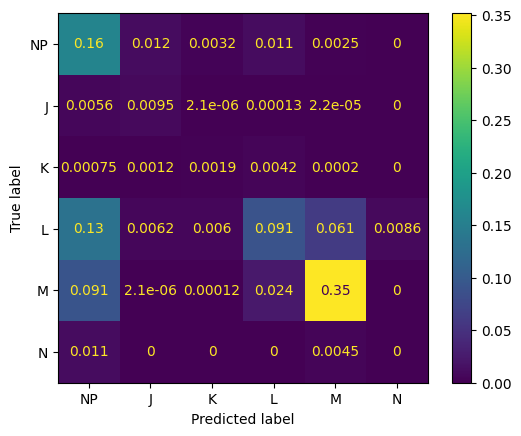

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(flat_Y_test, flat_Y_pred, labels = ["NP", "J", "K", "L", "M", "N"], normalize = "all")
ConfusionMatrixDisplay(cm, display_labels = ["NP", "J", "K", "L", "M", "N"]).plot()


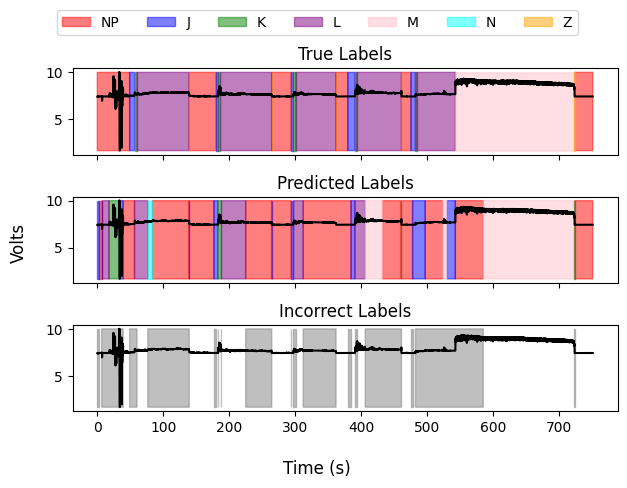

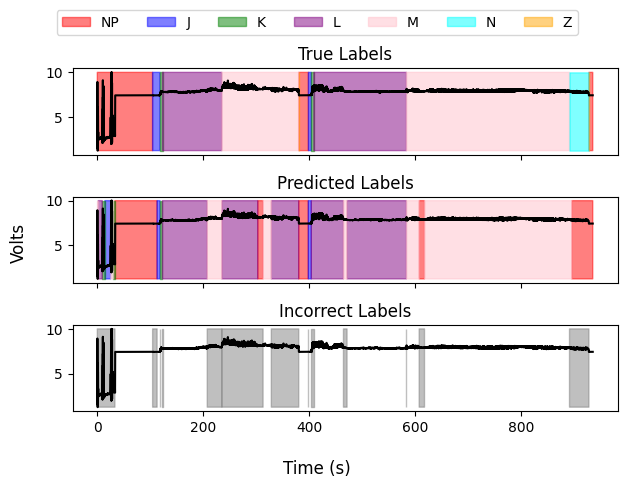

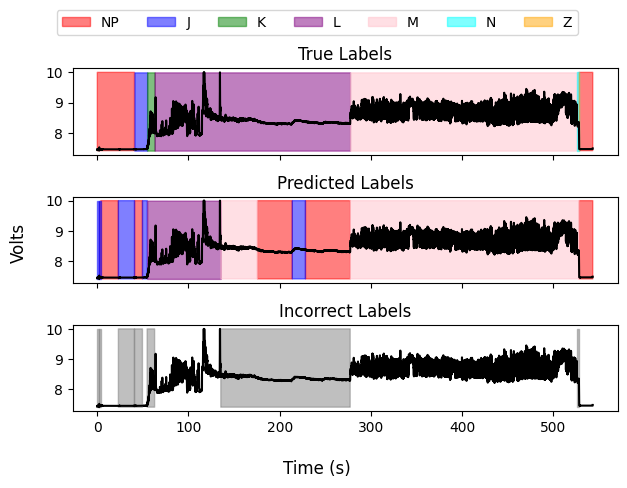

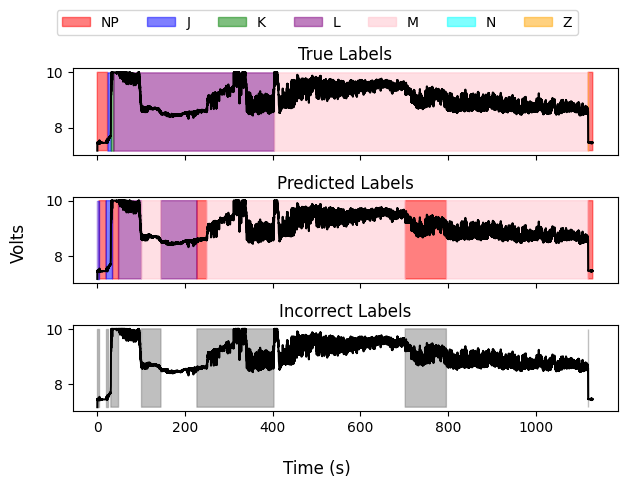

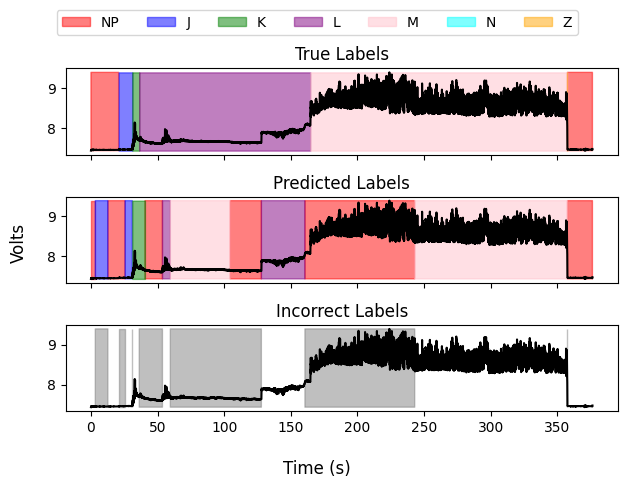

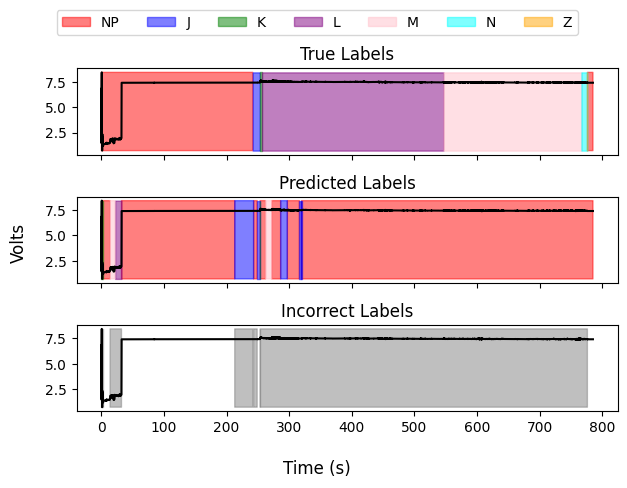

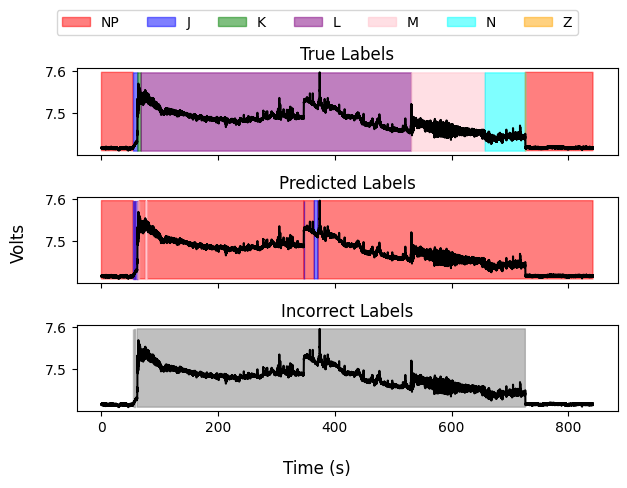

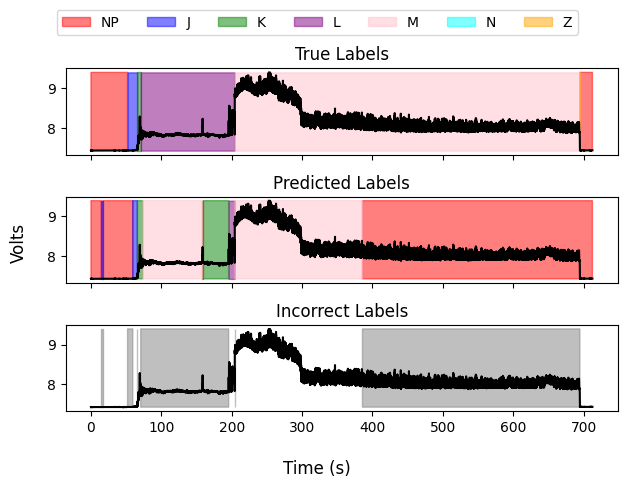

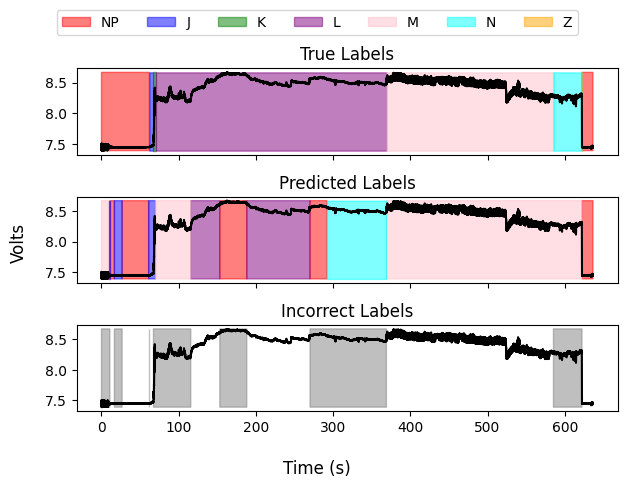

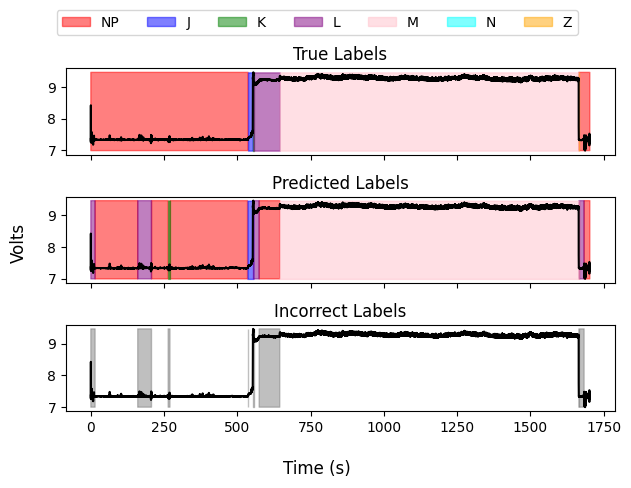

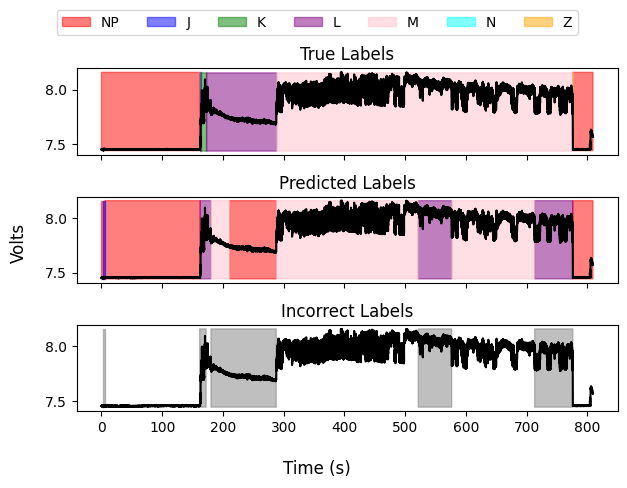

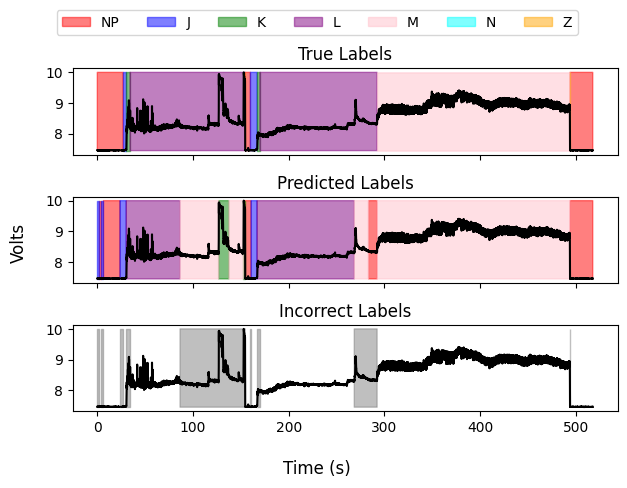

In [79]:
label_to_color = {
    "NP": "red",
    "J": "blue",
    "K": "green",
    "L": "purple",
    "M": "pink",
    "N": "cyan",
    "Z": "orange"
}

def plot_labels(time, voltage, true_labels, pred_labels):
    """
    plot_labels produced a matplotlib figure containing three subplots
        that visualize a waveform along with the true and predicted labels
    Input:
        time: a series of time values
        voltage: a time series of voltage values from the waveform
        true_labels: a time series of the true label for each time point
        pred_labels: a time series of the predicted labels for each time point
    Output:
        (fig, axs): a tuple
    """
    fig, axs = plt.subplots(3, 1, sharex = True)
    recording = 1
    fill_min, fill_max = voltage.min(), voltage.max()
    
    # First plot will be the true labels
    axs[0].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        fill = axs[0].fill_between(time, fill_min, fill_max, 
                where = (true_labels == label), color=color, alpha = 0.5)
        fill.set_label(label)
    axs[0].legend(bbox_to_anchor=(0.5, 1), 
                  bbox_transform=fig.transFigure, loc="upper center", ncol=9)
    axs[0].set_title("True Labels")
    # Second plot will be the predicted labels
    axs[1].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        axs[1].fill_between(time, fill_min, fill_max, 
                where = (pred_labels == label), color=color, alpha = 0.5)
    axs[1].set_title("Predicted Labels")
    # Third plot will be marked where there is a difference between the two
    axs[2].plot(time, voltage, color = "black")
    axs[2].fill_between(time[:len(pred_labels)], fill_min, fill_max, 
            where = (pred_labels != true_labels[:len(pred_labels)]), color = "gray", alpha = 0.5)
    axs[2].set_title("Incorrect Labels")
        # Axes titles and such
    fig.supxlabel("Time (s)")
    fig.supylabel("Volts")
    fig.tight_layout()
    
for i in range(12):
    plot_labels(np.arange(len(time_series[i])) / 100, rect_series[i], label_series[i], np.array(Y_test[i]))
